<a href="https://colab.research.google.com/github/onejbsmith/ExportedData/blob/main/Seq2Seq_LSTM_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 2: Seq2Seq LSTM Model with Luong Attention

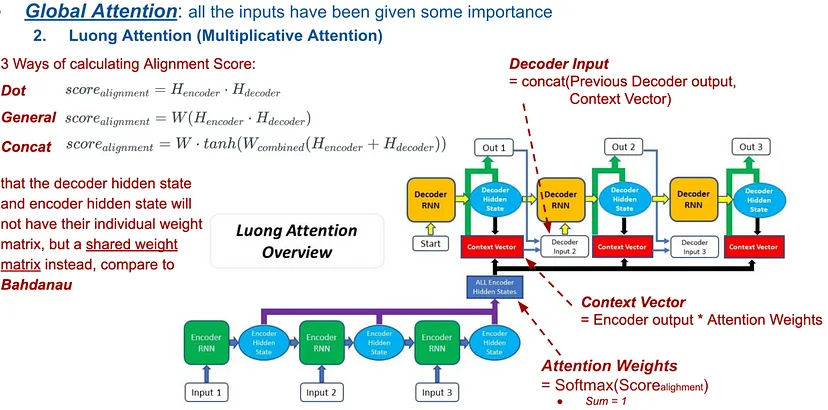

In [1]:
#@title #Import Packages

import random
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl

#!pip install keras
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd



In [2]:
#@title List Packages Installed
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
CacheControl                  0.12.11
cached-property               1.5.2
cachetools                    5.3.0
cata

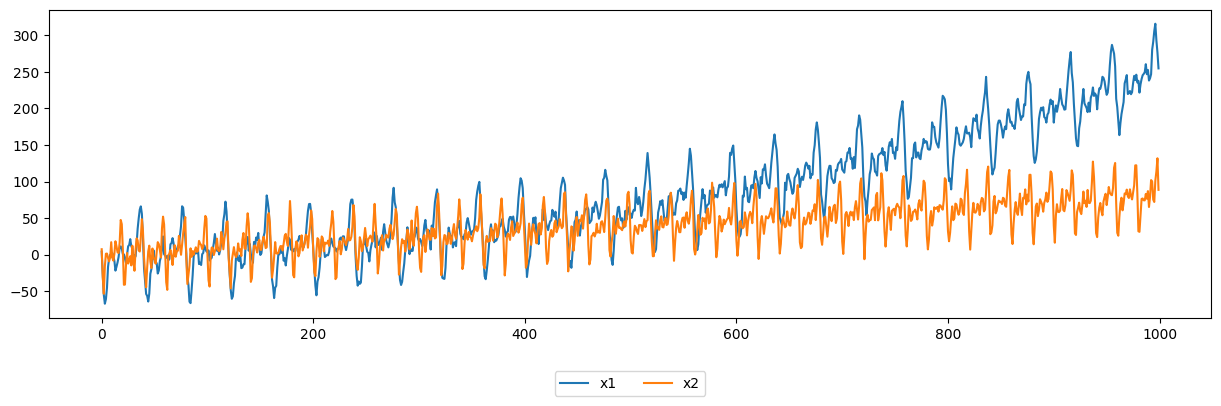

In [3]:
#@title Create Some Data
n_ = 1000
t = np.linspace(0, 50*np.pi, n_)
# pattern + trend + noise
x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

We’ve just created two sequences, x1 and x2, by combining sin waves, trend, and random noise. Next we will preprocess x1 and x2.

##Preprocess
1. Split `sequences` to 80% train set and 20% test set
2. Detrending
3. Combine sequences
4. Normalize
5. Truncate

In [4]:
#@title 1. Split sequences to 80% train set and 20% test set

train_ratio = 0.8
train_len = int(train_ratio * t.shape[0])
print(train_len)


800


Since the sequence length is n_ = 1000, the first 800 data points will be used as our train data, while the rest will be used as our test data.

##2. Detrending
It is not a must to detrend time series. However stationary time series will make model training much easier. There are many ways to detrend time series, such as taking difference of sequence with its lag1. Here for the simplicity, we assume the order of trend is known and we are just going to simply fit separate trend lines to x1 and x2, and then subtract the trend from the corresponding original sequence.

In [5]:
#@title ####We will create index number of each position in the sequence, for easier detrending and trend recover.
x_index = np.array(range(len(t)))

Here we will use np.polyfit to complete this small task. Note that only the first 800 data points are used to fit the trend lines, this is because we want to avoid data leak.

In [6]:
#@title PolyFit
x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)

[ 2.46441390e-04  5.37750355e-03 -2.15108460e+00]
[ 0.07934322 -0.64119786]


Based on the above values we got, we can now come up with the trend lines for x1 and x2.

In [7]:
#@title Trend Lines
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

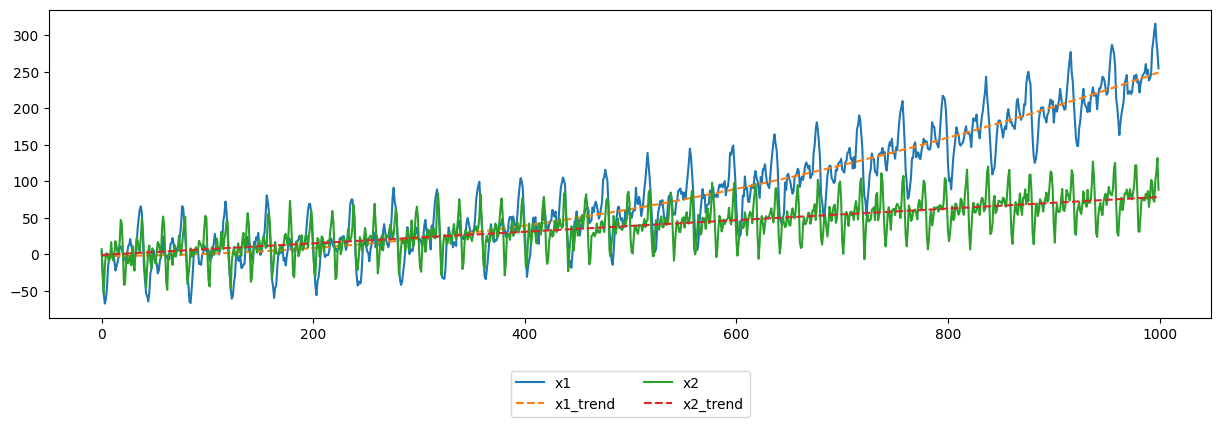

In [8]:
#@title Let’s plot the trend lines together with x1 and x2, and check if they look good.
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

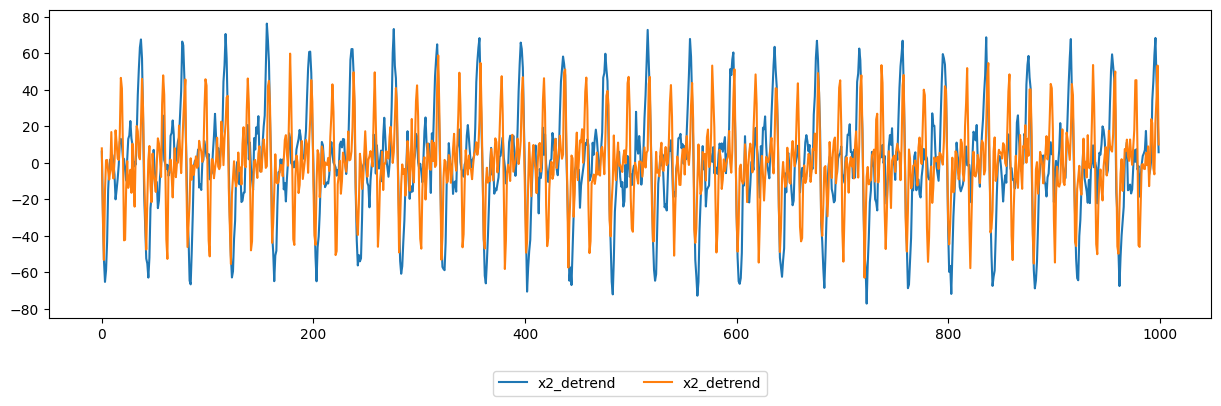

In [9]:
#@title The above result looks fine, now we can deduct the trend.
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

#3. Combine sequences
For easier preprocessing in next several steps, we can combine the sequences and their relevant information together into one array.

In [10]:
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(1000, 4)
[[  6.06573117   7.88634707   0.           1.        ]
 [-25.65264264 -30.41505156   1.           1.        ]
 [-52.97150946 -53.25784058   2.           1.        ]
 ...
 [ 45.20915314  35.2403822  997.           0.        ]
 [ 28.14857158  53.27637637 998.           0.        ]
 [  5.77127355  10.01325563 999.           0.        ]]


In the combined array we created *x_lbl*:

*    the first column is the *detrended x1*
*    the second column is the *detrended x2*
*    the third column is the *index*
*    the fourth column is the *label* (1 for train set and 0 for test set)

#4. Normalize
Normalisation can help model avoid favouring large features while ignoring very small features. Here we can just simply normalise x1 and x2 by dividing the corresponding maximum values in train set.

In [11]:
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

[76.25835866757231, 59.80970305219138, 1, 1]


Note that the above code only calculates maximum value of column 1 (*detrended x1*) and column 2 (*detrended x2*), the denominator of column 3 (*index*) and column 4 (*label*) are set to 1. This is because we do not input column 3 and column 4 into neural network, and hence no need to normalise them.



In [12]:
x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

[[ 7.95418532e-02  1.31857319e-01  0.00000000e+00  1.00000000e+00]
 [-3.36391224e-01 -5.08530389e-01  1.00000000e+00  1.00000000e+00]
 [-6.94632174e-01 -8.90454857e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 5.92841938e-01  5.89208446e-01  9.97000000e+02  0.00000000e+00]
 [ 3.69121131e-01  8.90764770e-01  9.98000000e+02  0.00000000e+00]
 [ 7.56805372e-02  1.67418581e-01  9.99000000e+02  0.00000000e+00]]


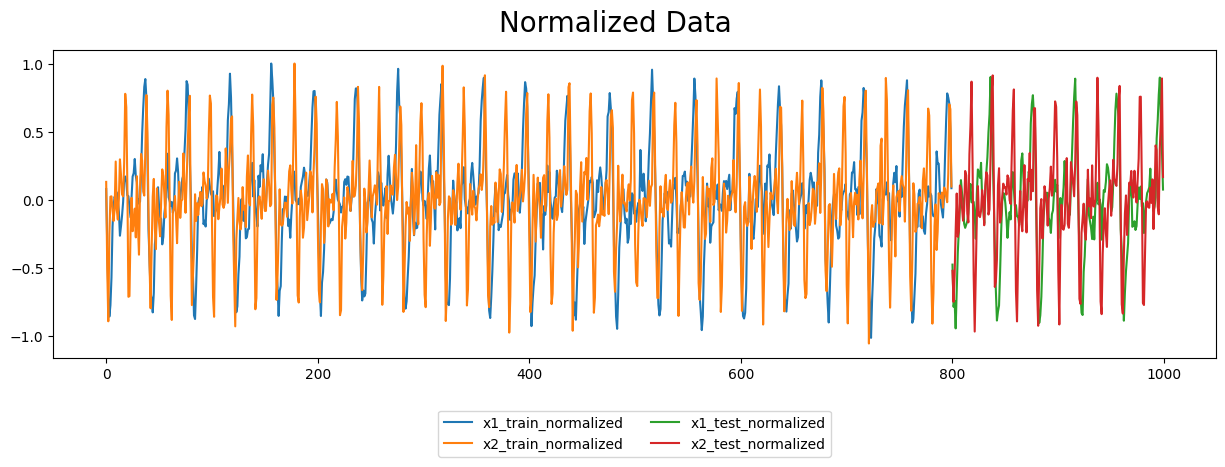

In [13]:
fig = plt.figure(figsize=(15, 4))
fig.suptitle('Normalized Data', fontsize=20)
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

After normalisation, all the values are more or less within range from -1 to 1.

#5. Truncate
Next, we will cut sequence into smaller pieces by sliding an input window (length = 200 time steps) and an output window (length = 20 time steps), and put these samples in 3d numpy arrays.
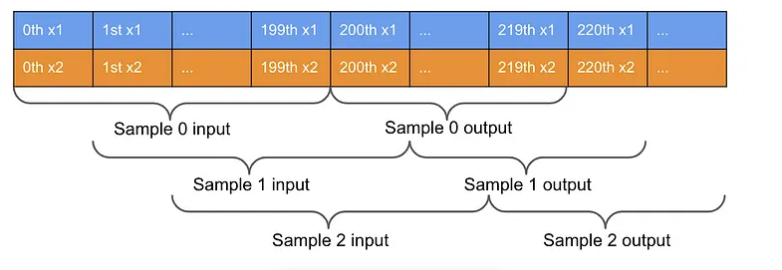


In [14]:
#@title Truncate Function
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 3) (781, 20, 3) (781,)


The function truncate generates 3 arrays:

*  input to neural network *X_in*: it contains 781 samples, length of each sample is 200 time steps, and each sample contains 3 features: *detrended and normalised x1, detrended and normalised x2*, and *original assigned data position index*. Only the first 2 features will be used for training.
*  target in neural network *X_out*: it contains 781 samples, length of each sample is 20 time steps, and each sample contains the same 3 features as in *X_in*. Only the first 2 features will be used as target, and the third feature will only be used to recover trend of the prediction.
*  label *lbl*: 1 for train set and 0 for test set.## 

In [16]:
#@title Train and Test Sets
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


One of the limitations of simple Seq2Seq model is: only the last state of encoder RNN is used as input to decoder RNN. If the sequence is very long, the encoder will tend to have much weaker memory about earlier time steps. Attention mechanism can solve this problem. An attention layer is going to assign proper weight to each hidden state output from encoder, and map them to output sequence.

Next we will build **Luong Attention** on top of **_Model 1_**, and use _Dot_ method to calculate alignment score.

**The** **Input layer**

It is the same as in **_Model 1_**:

In [17]:
n_hidden = 100
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

**The encoder LSTM**

This is slightly different from **_Model 1_**: besides returning the last hidden state and the last cell state, we also need to return the stacked hidden states for **_alignment score_** calculation.

In [18]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 100), dtype=tf.float32, name=None), name='lstm/transpose_1:0', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")


In [19]:
#@title Next, we apply batch normalisation to avoid gradient explosion.

encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

**The Decoder LSTM**

Next, we repeat the last hidden state of encoder 20 times, and use them as input to decoder LSTM.

In [20]:
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")


In [21]:
#@title #####We also need to get the stacked hidden state of de decoder for **_alignment score_** calculation.
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")


**Attention Layer**

To build the attention layer, the first thing to do is to calculate the alignment score, and apply softmax activation function over it:

In [22]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 200), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


In [23]:
#@title #####Then we can calculate the context vector, and also apply batch normalisation on top of it:
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='batch_normalization_2/batchnorm/add_1:0', description="created by layer 'batch_normalization_2'")


In [25]:
#@title #####Now we concat the context vector and stacked hidden states of decoder, and use it as input to the last dense layer.
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 200), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [26]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")


In [27]:
#@title #####Then we can compile the model. The parameters are the same as those in **_Model 1_**, for the sake of comparing the performance of the 2 models.
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 2)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 200, 100),   41200       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 batch_normalization (BatchNorm  (None, 100)         400         ['lstm[0][1]']                   
 alization)                                                                                   

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


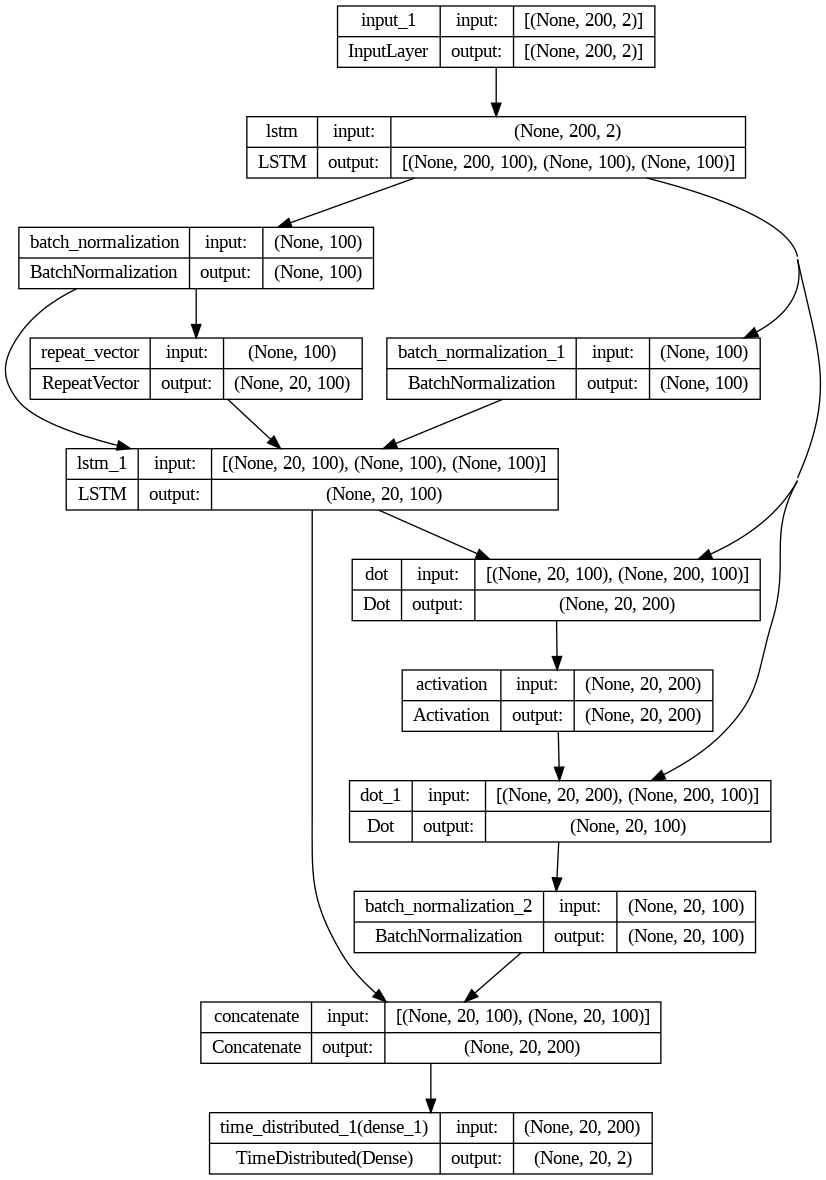

In [28]:
#@title #####We can also plot the model:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#**The next step is training:**

In [ ]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

Epoch 1/100
5/5 [==============================] - 12s 886ms/step - loss: 5.6782 - mae: 1.1088 - val_loss: 0.1509 - val_mae: 0.2856
Epoch 2/100
5/5 [==============================] - 5s 964ms/step - loss: 0.1696 - mae: 0.3145 - val_loss: 0.1433 - val_mae: 0.2785
Epoch 3/100
5/5 [==============================] - 4s 729ms/step - loss: 0.1366 - mae: 0.2736 - val_loss: 0.2117 - val_mae: 0.3628
Epoch 4/100
5/5 [==============================] - 3s 704ms/step - loss: 0.1282 - mae: 0.2635 - val_loss: 0.1525 - val_mae: 0.3012
Epoch 5/100
5/5 [==============================] - 4s 724ms/step - loss: 0.1184 - mae: 0.2534 - val_loss: 0.1201 - val_mae: 0.2561
Epoch 6/100
5/5 [==============================] - 5s 866ms/step - loss: 0.1139 - mae: 0.2501 - val_loss: 0.1109 - val_mae: 0.2474
Epoch 7/100
5/5 [==============================] - 3s 687ms/step - loss: 0.1105 - mae: 0.2479 - val_loss: 0.1054 - val_mae: 0.2449
Epoch 8/100
5/5 [==============================] - 3s 696ms/step - loss: 0.1055 - 

In [ ]:
#@title #####Training Results plot
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# Prediction
The model prediction as well as the true values are unnormalised:

In [ ]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

In [ ]:
#@title #####Then we combine the unnormalised outputs with their corresponding index, so that we can recover the trend.
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)


In [ ]:
#@title #####Next, we put all the outputs with recovered trend into a dictionary **_data\_final_**.

data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

In [ ]:
#@title #####Just a quick check to see if the prediction value distribution is reasonable:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

The data distribution of prediction and true values are almost overlapped, so we are good.

We can also plot MAE of all samples in time order, to see if there is clear pattern. ***The ideal situation is when line is random, otherwise it may indicate that the model is not sufficiently trained.***

In [ ]:

for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

Based on the above plots, we can say that there are still certain periodical pattens in both train and test MAE. Training for more epochs may lead to better results.

Next we are going to check some random samples and see if the predicted lines and corresponding true lines are aligned.

In [ ]:
#@title #####We can also check the nth prediction of each time step:

ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

In [ ]:
#@title #####Take a closer look at the prediction on test set:

plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()